# World Population

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [3]:
# import functions from modsim

from modsim import *

In 1968 Paul Erlich published *The Population Bomb*, in which he
predicted that world population would grow quickly during the 1970s,
that agricultural production could not keep up, and that mass starvation in the next two decades was inevitable (see
<https://modsimpy.com/popbomb>). As someone who grew up during those
decades, I am happy to report that those predictions were wrong.

But world population growth is still a topic of concern, and it is an
open question how many people Earth can sustain while maintaining
and improving our quality of life.

In this chapter and the next, we use tools from the previous chapters to model world population growth since 1950 and generate predictions for the next 50-100 years.
For background on world population growth, watch this video from the
American Museum of Natural History <https://modsimpy.com/human>.

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

## World Population Growth

The Wikipedia article on world population contains tables with estimates of world population from prehistory to the present, and projections for the future (<https://modsimpy.com/worldpop>).

The following cell downloads a copy of https://en.wikipedia.org/wiki/World_population_estimates

In [4]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/data/World_population_estimates.html')

To read this data, we will use the Pandas library, which provides functions for
working with data. The function we'll use is `read_html`, which can read a web page and extract data from any tables it contains. Before we can use it, we have to import it.

In [5]:
from pandas import read_html

Now we can use it like this:

In [6]:
filename = 'World_population_estimates.html'
tables = read_html(filename,
                   header=0, 
                   index_col=0,
                   decimal='M')

The arguments are:

-   `filename`: The name of the file (including the directory it's in)
    as a string. This argument can also be a URL starting with `http`.

-   `header`: Indicates which row of each table should be considered the
    *header*, that is, the set of labels that identify the columns. In
    this case it is the first row (numbered 0).

-   `index_col`: Indicates which column of each table should be
    considered the *index*, that is, the set of labels that identify
    the rows. In this case it is the first column, which contains the
    years.

-   `decimal`: Normally this argument is used to indicate which
    character should be considered a decimal point, because some
    conventions use a period and some use a comma. In this case I am
    abusing the feature by treating `M` as a decimal point, which allows
    some of the estimates, which are expressed in millions, to be read
    as numbers.

The result, which is assigned to `tables`, is a sequence that contains
one `DataFrame` for each table. A `DataFrame` is an object, defined by
Pandas, that represents tabular data.

To select a `DataFrame` from `tables`, we can use the bracket operator
like this:

In [7]:
table2 = tables[2]

This line selects the third table (numbered 2), which contains
population estimates from 1950 to 2016.

We can use `head` to display the first few lines of the table.

In [8]:
table2.head()

,United States Census Bureau (2017)[28],Population Reference Bureau (1973–2016)[15],United Nations Department of Economic and Social Affairs (2015)[16],Maddison (2008)[17],HYDE (2007)[24],Tanton (1994)[18],Biraben (1980)[19],McEvedy & Jones (1978)[20],Thomlinson (1975)[21],Durand (1974)[22],Clark (1967)[23]
Year,,,,,,,,,,,
1950,2557628654,2.516000e+09,2.525149e+09,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,2594939877,NaN,2.572851e+09,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,2636772306,NaN,2.619292e+09,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,2682053389,NaN,2.665865e+09,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,2730228104,NaN,2.713172e+09,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first column, which is labeled `Year`, is special.  It is the *index* for this `DataFrame`, which means it contains the labels for the rows.

Some of the values use scientific notation; for example, `2.516000e+09` is shorthand for $2.516 \cdot 10^9$ or 2.544 billion.

`NaN` is a special value that indicates missing data.

The column labels are long strings, which makes them hard to work with.
We can replace them with shorter strings like this:

In [9]:
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

Now we can select a column from the `DataFrame` using the dot operator,
like selecting a state variable from a `State` object.

Here are the estimates from the United States Census Bureau:

In [10]:
census = table2.census / 1e9

The result is a Pandas `Series`, which is similar to the `TimeSeries` and `SweepSeries` objects we've been using.

The number `1e9` is a shorter way to write `1000000000` or one billion.
When we divide a `Series` by a number, it divides all of the elements of the `Series`.
From here on, we'll express population estimates in terms of billions.

We can use `tail` to see the last few elements of the `Series`:

In [11]:
census.tail()

Year
2012    7.013871
2013    7.092128
2014    7.169968
2015    7.247893
2016    7.325997
Name: census, dtype: float64

The left column is the *index* of the `Series`; in this example it contains the dates.
The right column contains the *values*, which are population estimates.
In 2016 the world population was about 7.3 billion.

Here are the estimates from the United Nations
Department of Economic and Social Affairs (U.N. DESA):

In [12]:
un = table2.un / 1e9
un.tail()

Year
2012    7.080072
2013    7.162119
2014    7.243784
2015    7.349472
2016         NaN
Name: un, dtype: float64

The most recent estimate we have from the U.N. is for 2015, so the value for 2016 is `NaN`.

Now we can plot the estimates like this:

In [13]:
def plot_estimates():
    census.plot(style=':', label='US Census')
    un.plot(style='--', label='UN DESA')
    decorate(xlabel='Year', 
             ylabel='World population (billions)') 

The keyword argument `style=':'` specifies a dotted line; `style='--'` specifies a dashed line.
The `label` argument provides the string that appears in the legend.

And here's what it looks like.

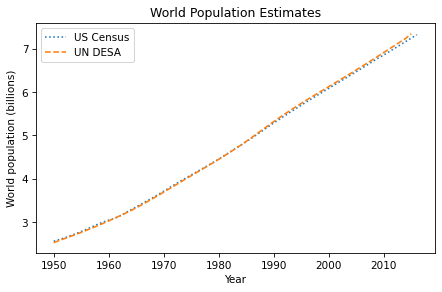

In [14]:
plot_estimates()
decorate(title='World Population Estimates')

The lines overlap almost completely, but the most recent estimates diverge slightly.
In the next section, we'll quantify these differences.

## Absolute and Relative Errors

Estimates of world population from the U.S. Census and the U.N. DESA differ slightly.
One way to characterize this difference is *absolute error*, which is the absolute value of the difference between the estimates.

To compute absolute errors, we can import `abs` from NumPy:

In [15]:
from numpy import abs

And use it like this:

In [16]:
abs_error = abs(un - census)
abs_error.tail()

Year
2012    0.066201
2013    0.069991
2014    0.073816
2015    0.101579
2016         NaN
dtype: float64

When you subtract two `Series` objects, the result is a new `Series`.
Because one of the estimates for 2016 is `NaN`, the result for 2016 is `NaN`.

To summarize the results, we can compute the *mean absolute error*.

In [17]:
from numpy import mean

mean(abs_error)

0.029034508242424265

On average, the estimates differ by about 0.029 billion.
But we can also use `max` to compute the maximum absolute error.

In [18]:
from numpy import max

max(abs_error)

0.10157921199999986

In the worst case, they differ by about 0.1 billion.

Now 0.1 billion is a lot of people, so that might sound like a serious discrepancy.
But counting everyone is the world is hard, and we should not expect the estimates to be exact.

Another way to quantify the magnitude of the difference is *relative error*, which is the size of the error divided by the estimates themselves.

In [19]:
rel_error = 100 * abs_error / census
rel_error.tail()

Year
2012    0.943860
2013    0.986888
2014    1.029514
2015    1.401500
2016         NaN
dtype: float64

I multiplied by 100 so we can interpret the results as a percentage.  In 2015, the difference between the estimates is about 1.4%, and that happens to be the maximum.

Again, we can summarize the results by computing the mean.

In [20]:
mean(rel_error)

0.5946585816022846

The mean relative error is about 0.6%.
So that's not bad.

You might wonder why I divided by `census` rather than `un`.
In general, if you think one estimate is better than the other, you put the better one in the denominator.
In this case, I don't know which is better, so I put the smaller one in the denominator, which makes the computed errors a little bigger.

## Modeling Population Growth

Suppose we want to predict world population growth over the next 50 or
100 years. We can do that by developing a model that describes how
populations grow, fitting the model to the data we have so far, and then using the model to generate predictions.

In the next few sections I demonstrate this process starting with simple models and gradually improving them.

Although there is some curvature in the plotted estimates, it looks like world population growth has been close to linear since 1960 or so. So we'll start with a model that has constant growth.

To fit the model to the data, we'll compute the average annual growth
from 1950 to 2016. Since the UN and Census data are so close, we'll use the Census data.

We can select a value from a `Series` using the bracket operator:

In [21]:
census[1950]

2.557628654

So we can get the total growth during the interval like this:

In [22]:
total_growth = census[2016] - census[1950]

In this example, the labels 2016 and 1950 are part of the data, so it
would be better not to make them part of the program. 
Putting values like these in the program is called *hard coding*; it is considered bad practice because if the data change in the future, we have to change the program (see <https://modsimpy.com/hardcode>).

It would be better to get the labels from the `Series`.
We can do that by selecting the index from `census` and then selecting the first element.

In [23]:
t_0 = census.index[0]
t_0

1950

So `t_0` is the label of the first element, which is 1950.
We can get the label of the last element like this.

In [24]:
t_end = census.index[-1]
t_end

2016

The value `-1` indicates the last element; `-2` indicates the second to last element, and so on.

The difference between `t_0` and `t_end` is the elapsed time between them.

In [25]:
elapsed_time = t_end - t_0
elapsed_time

66

Now we can use `t_0` and `t_end` to select the population at the beginning and end of the interval.

In [26]:
p_0 = census[t_0]
p_end = census[t_end]

And compute the total growth during the interval.

In [27]:
total_growth = p_end - p_0
total_growth

4.768368055

Finally, we can compute average annual growth.

In [28]:
annual_growth = total_growth / elapsed_time
annual_growth

0.07224800083333333

From 1950 to 2016, world population grew by about 0.07 billion people per year, on average.
The next step is to use this estimate to simulate population growth.

## Simulating Population Growth

Our simulation will start with the observed population in 1950, `p_0`,
and add `annual_growth` each year. To store the results, we'll use a
`TimeSeries` object:

In [29]:
results = TimeSeries()

We can set the first value in the new `TimeSeries` like this.

In [30]:
results[t_0] = p_0

Here's what it looks like so far.

In [31]:
show(results)

,Quantity
Time,
1950,2.557629


Now we set the rest of the values by simulating annual growth:

In [32]:
for t in range(t_0, t_end):
    results[t+1] = results[t] + annual_growth

The values of `t` go from `t_0` to `t_end`, including the first but not the last.

Inside the loop, we compute the population for the next year by adding the population for the current year and `annual_growth`. 

The last time through the loop, the value of `t` is 2015, so the last label in `results` is 2016.

Here's what the results look like, compared to the estimates.

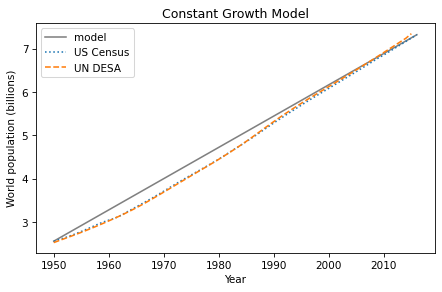

In [33]:
results.plot(color='gray', label='model')
plot_estimates()
decorate(title='Constant Growth Model')

From 1950 to 1990, the model does not fit the data particularly well, but after that, it's pretty good.

## Summary

This chapter is a first step toward modeling changes in world population growth during the last 70 years.

We used Pandas to read data from a web page and store the results in a `DataFrame`.
From the `DataFrame` we selected two `Series` objects and used them to compute absolute and relative errors.

Then we computed average population growth and used it to build a simple model with constant annual growth.
The model fits recent data pretty well; nevertheless, there are two reasons we should be skeptical:

* There is no obvious mechanism that could cause population growth to be constant from year to year. Changes in population are determined by the fraction of people who die and the fraction of people who give birth, so we expect them to depend on the current population.

* According to this model, world population would keep growing at the same rate forever, and that does not seem reasonable.

In the next chapter we'll consider other models that might fit the data better and make more credible predictions.

## Exercises

Here's the code from this chapter all in one place.

In [34]:
t_0 = census.index[0]
t_end = census.index[-1]
elapsed_time = t_end - t_0

p_0 = census[t_0]
p_end = census[t_end]

total_growth = p_end - p_0
annual_growth = total_growth / elapsed_time

results = TimeSeries()
results[t_0] = p_0

for t in range(t_0, t_end):
    results[t+1] = results[t] + annual_growth

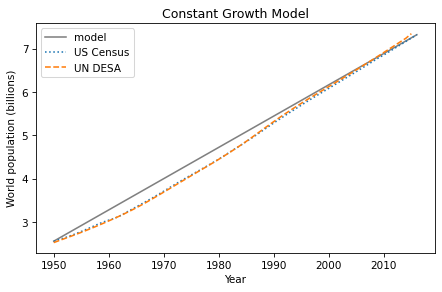

In [35]:
results.plot(color='gray', label='model')
plot_estimates()
decorate(title='Constant Growth Model')

### Exercise 1

  Try fitting the model using data from 1970 to the present, and see if that does a better job.

Suggestions: 

1. Define `t_1` to be 1970 and `p_1` to be the population in 1970.  Use `t_1` and `p_1` to compute annual growth, but use `t_0` and `p_0` to run the simulation. 

2. You might want to add a constant to the starting value to match the data better.

In [36]:
# Solution

t_0 = census.index[0]
t_1 = 1970
t_end = census.index[-1]
elapsed_time = t_end - t_1

p_0 = census[t_0]
p_1 = census[t_1]
p_end = census[t_end]

total_growth = p_end - p_1
annual_growth = total_growth / elapsed_time
annual_growth

0.07854997754347826

In [37]:
# Solution

results = TimeSeries()
results[t_0] = p_0 - 0.45

for t in range(t_0, t_end):
    results[t+1] = results[t] + annual_growth

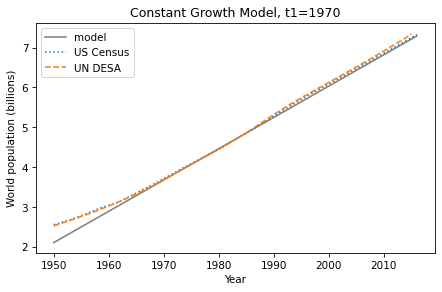

In [38]:
# Solution

results.plot(color='gray', label='model')
plot_estimates()
decorate(title='Constant Growth Model, t1=1970')